In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#import imageio
from nst_utils import *
import numpy as np
import tensorflow as tf
import time
from decimal import Decimal
%matplotlib inline

In [4]:
'''
def get_weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        vgg_layers = vgg['layers']
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b
'''

'\ndef get_weights(layer, expected_layer_name):\n        """\n        Return the weights and bias from the VGG model for a given layer.\n        """\n        vgg_layers = vgg[\'layers\']\n        wb = vgg_layers[0][layer][0][0][2]\n        W = wb[0][0]\n        b = wb[0][1]\n        layer_name = vgg_layers[0][layer][0][0][0][0]\n        assert layer_name == expected_layer_name\n        return W, b\n\n        return W, b\n'

In [5]:
'''
path = "pretrained-model/imagenet-vgg-verydeep-19.mat"
vgg = scipy.io.loadmat(path)
'''

'\npath = "pretrained-model/imagenet-vgg-verydeep-19.mat"\nvgg = scipy.io.loadmat(path)\n'

In [6]:
'''
W,b = get_weights(14,'conv3_3')
W1,b1 = get_weights(16,'conv3_4')
#W = W.reshape(64,3*3*3)
#n_H, n_W, n_C,m = W.get_shape().as_list()
#print(m,n_H,n_W,n_C)    
#chng = tf.reshape(a_C,[m,n_C*n_W*n_H])

print ("w = ",W.shape,", b = ",b.shape,"w1= ",W1.shape," b1= ",b1.shape)
val = np.sum(np.abs(W1-W))
print("val= " ,val)

#print(W)
'''

'\nW,b = get_weights(14,\'conv3_3\')\nW1,b1 = get_weights(16,\'conv3_4\')\n#W = W.reshape(64,3*3*3)\n#n_H, n_W, n_C,m = W.get_shape().as_list()\n#print(m,n_H,n_W,n_C)    \n#chng = tf.reshape(a_C,[m,n_C*n_W*n_H])\n\nprint ("w = ",W.shape,", b = ",b.shape,"w1= ",W1.shape," b1= ",b1.shape)\nval = np.sum(np.abs(W1-W))\nprint("val= " ,val)\n\n#print(W)\n'

In [7]:
'''
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)
'''

'\ncontent_image = scipy.misc.imread("images/louvre.jpg")\nimshow(content_image)\n'

In [8]:

def compute_content_cost(a_C, a_G):
    """
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    #print(m,n_H,n_W,n_C)    
    a_C_2d = tf.reshape(a_C,[m,n_C,n_W*n_H])
    a_G_2d = tf.reshape(a_G,[m,n_C,n_W*n_H])
   
    J_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_2d,a_G_2d))))
    # Overall it is summation of element wise subtraction of respective activations of content and G image. 
    #J_content is a single value
    return J_content

In [9]:
# Testing the content cost function.
'''tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
'''

'tf.reset_default_graph()\n\nwith tf.Session() as test:\n    tf.set_random_seed(1)\n    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)\n    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)\n    J_content = compute_content_cost(a_C, a_G)\n    print("J_content = " + str(J_content.eval()))\n'

In [10]:
'''
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)'''

'\nstyle_image = scipy.misc.imread("images/monet_800600.jpg")\nimshow(style_image)'

In [11]:

def gram_matrix(A):
        
    GA = tf.matmul(A,tf.transpose(A))
    #print(GA)
    # GA is a matrix of dimension nc * nc. It contains the correlation value of all channels with all other channels.
    return GA

In [12]:
'''
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval())) 
'''

'\ntf.reset_default_graph()\n\nwith tf.Session() as test:\n    tf.set_random_seed(1)\n    A = tf.random_normal([3, 2*1], mean=1, stddev=4)\n    GA = gram_matrix(A)\n    \n    print("GA = " + str(GA.eval())) \n'

In [13]:

def compute_layer_style_cost(a_S, a_G):
       
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
   
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))

    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    #Loss function
    #print(GS)
    #print(GG)
    J_style_layer = tf.reduce_sum(tf.square(GS-GG)) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [14]:
'''
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))
'''

'\ntf.reset_default_graph()\n\nwith tf.Session() as test:\n    tf.set_random_seed(1)\n    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)\n    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)\n    J_style_layer = compute_layer_style_cost(a_S, a_G)\n    \n    print("J_style_layer = " + str(J_style_layer.eval()))\n'

In [15]:
'''
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv1_2', 0.2),
    ('conv3_1', 0.2),
    ('conv3_2', 0.2),
    ('conv4_1', 0.2),
    ('conv4_2', 0.2),
    ('conv5_1', 0.2),
    ('conv5_2', 0.2),

]

'''

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2),
    ]


In [16]:
def compute_style_cost(model, STYLE_LAYERS):
        
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

       #output tensor
        out = model[layer_name]

        # Set a_S to be the hidden layer activation  by running the session on out.
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. 
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [17]:

def total_cost(J_content, J_style, alpha, beta):
    
    J = alpha*J_content + beta*J_style
    
    return J

In [18]:
'''
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))
'''

'\ntf.reset_default_graph()\n\nwith tf.Session() as test:\n    np.random.seed(3)\n    J_content = np.random.randn()    \n    J_style = np.random.randn()\n    J = total_cost(J_content, J_style)\n    print("J = " + str(J))\n'

In [19]:
# Reset the graph
tf.reset_default_graph()

sess = tf.InteractiveSession()

C:\Users\Siddhant\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
C:\Users\Siddhant\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


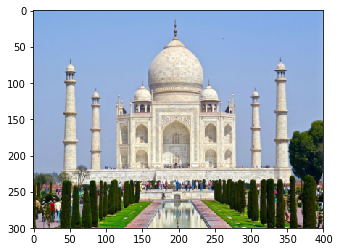

In [20]:
content_image = scipy.misc.imread("images/taj-mahal.jpg")
content_image = scipy.misc.imresize(content_image,(300,400))
content_image.shape
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)


C:\Users\Siddhant\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
C:\Users\Siddhant\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


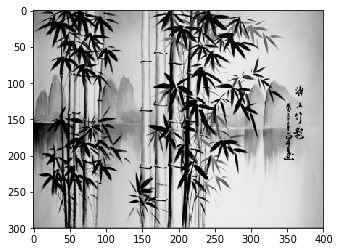

In [21]:
style_image = scipy.misc.imread("images/bamboo_forest.jpg")
style_image = scipy.misc.imresize(style_image,(300,400))
style_image.shape
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

In [22]:
CONFIG.NOISE_RATIO

0.3

In [23]:

#generated_image = generate_noise_image(content_image)
generated_image = generate_noise_image(content_image)

#imshow(generated_image[0])

0.3


In [24]:

model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [25]:
 #compute content cost
sess.run(model['input'].assign(content_image))

out = model['conv4_2'] # tensorflow session will compute activations at the conv4_2 layer
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. 
a_G = out

J_content = compute_content_cost(a_C, a_G)
'''
print (out.shape)
t = model['conv1_1']
print (t.shape)

t = model['conv1_2']
print (t.shape)

t = model['conv2_1']
print (t.shape)

t = model['conv2_2']
print (t.shape)
t = model['conv3_1']
print (t.shape)
t = model['conv3_2']
print (t.shape)
t = model['conv3_3']
print (t.shape)
t = model['conv3_4']
print (t.shape)

t = model['conv4_1']
print (t.shape)

t = model['conv4_2']
print (t.shape)
'''



"\nprint (out.shape)\nt = model['conv1_1']\nprint (t.shape)\n\nt = model['conv1_2']\nprint (t.shape)\n\nt = model['conv2_1']\nprint (t.shape)\n\nt = model['conv2_2']\nprint (t.shape)\nt = model['conv3_1']\nprint (t.shape)\nt = model['conv3_2']\nprint (t.shape)\nt = model['conv3_3']\nprint (t.shape)\nt = model['conv3_4']\nprint (t.shape)\n\nt = model['conv4_1']\nprint (t.shape)\n\nt = model['conv4_2']\nprint (t.shape)\n"

In [26]:
#compute style cost
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [27]:

#base = sess.run(model['input']) #assign input image to base

#gen_fixed = fixed_image_tf(gener)
#base = fixed_image_tf(base)

In [28]:
    
#rmse = 
#rmse = calc_rmse()

In [29]:
alpha = 10
beta = 100
J = total_cost(J_content,J_style,alpha,beta)

In [30]:

tf.summary.scalar("content_cost", J_content)
tf.summary.scalar("style_cost", J_style)
tf.summary.scalar("total_cost", J)
#tf.summary.scalar("RMSE_test", rmse)


<tf.Tensor 'total_cost:0' shape=() dtype=string>

In [31]:
summary_op = tf.summary.merge_all()

In [32]:
writer = tf.summary.FileWriter('tboard', graph = tf.get_default_graph())

In [33]:

optimizer = tf.train.AdamOptimizer(2)
#Adam optimizer does gradient descent. learning rate is 2



In [34]:
#writer = tf.summary.FileWriter('tboard', graph=tf.get_default_graph())

In [35]:
#optimizer = tf.train.RMSPropOptimizer(2)

In [36]:
#optimizer = tf.train.AdadeltaOptimizer(0.01)

In [37]:
train_step = optimizer.minimize(J)

In [38]:
#import to calculate structural similarity in next step.
#from skimage.measure import structural_similarity as ssim

In [ ]:


def model_nn(sess, input_image, num_iterations = 150):
    
    
    
    
    #b1 = sess.run(model['input'])
    #b1 = fixed_image(b1)
    #initially input image is the generated noisy image.
    sess.run(tf.global_variables_initializer())
    #writer = tf.summary.FileWriter('tboard/', graph=tf.get_default_graph())
    
    sess.run(model['input'].assign(input_image))
           
    #base_copy =  base
    startTime = time.time()
    for i in range(num_iterations):
        start = time.time()
        #This session minimizes the total cost.
        sess.run(train_step)
        
        generated_image,summary = sess.run([model['input'],summary_op])
        #generated_image = sess.run(model['input'])
        #print ("gen_shape = ",generated_image.shape)
        
        
        writer.add_summary(summary,i)
        
        Jt, Jc, Js = sess.run([J, J_content, J_style])
            
        #content_list.append(Jc)
        #style_list.append(Js)
        #total_list.append(Jt)
        itr_time = "{0:.2f}".format(time.time() - start)
        total_time = "{0:.2f}".format(time.time() - startTime)
            
        gen_image_fixed = fixed_image(generated_image)
            
            #a = calc_rmse(b1,gen_image_fixed)
            #b1 = gen_image_fixed
            #s = ssim(base,gen_image_fixed,multichannel = True)
            #s = round(s,3)
            #ssim_list.append(s)
            
            #rmse = round(calc_rmse(base, gen_image_fixed),3)
            #rate = rmse/np.sum(base)
            #print ("rmse = ",Jr)
            #rmse_list.append(rmse)
            #base = gen_image_fixed
            
            
        print("\nIteration " + str(i) + " :")
        print("total cost = " + "{:.2E}".format(Decimal(str(Jt))))
        print("content cost = " + str(Jc))
        print("style cost = " + "{:.2E}".format(Decimal(str(Js))))
        #print("rate: ",rate)
        #print("RMSE: ",a)
        #print("ssim = ",s)
        print("time for iteration : ",itr_time)
        print("Total time elapsed : ",total_time)
            
        #file_rmse.write(str(rmse)+"\n")
            
        '''
        file.write("\n\nIteration " + str(i) + " : ")
        file.write("\n\ntotal cost = " + "{:.2E}".format(Decimal(str(Jt))))
        file.write("\ncontent cost = " + str(Jc))
        file.write("\nstyle cost = " + "{:.2E}".format(Decimal(str(Js))))
                                
        #file.write("\nrate = " + str(rate))
        file.write("RMSE: "+ str(rmse))
        file.write("SSIM = " + str(s))
      
        file.write("\niteration time = " + str(itr_time))
        file.write("\nTotal time = " + str(total_time))
        '''
            
            #path = "output/test_images/"
            #imageio.imwrite(path + str(i) + ".jpg", gen_image_fixed)
            
    #imageio.imwrite(path + 'generated_image.jpg', gen_image_fixed)
    #file.write("\n\n Total time to run program: "+str(total_time))

    return generated_image
    

In [ ]:
#file.close()
#file = open('logs/full_style_layers_wolf.txt','w+')
#file = open('logs/new/ab=0.01.txt','w+')
#file_rmse = open('Logs/rmse/test.txt','w+')
'''
rmse_list = []
ssim_list = []
content_list = []
style_list = []
total_list = []
'''
final = model_nn(sess, generated_image)
#file.close()
#file_rmse.close()


Iteration 0 :
total cost = 2.07E+10
content cost = 3348.42
style cost = 2.07E+8
time for iteration :  20.55
Total time elapsed :  20.55

Iteration 1 :
total cost = 1.93E+10
content cost = 4008.05
style cost = 1.93E+8
time for iteration :  15.81
Total time elapsed :  36.39

Iteration 2 :
total cost = 1.80E+10
content cost = 4668.71
style cost = 1.80E+8
time for iteration :  15.83
Total time elapsed :  52.23

Iteration 3 :
total cost = 1.69E+10
content cost = 5351.04
style cost = 1.69E+8
time for iteration :  15.70
Total time elapsed :  67.94


In [ ]:
#file_rmse.close()
'''file_rmse = open('logs/rmse/f1.txt','w+')
for i in range(0,len(iter_list)):
    file_rmse.write(str(rmse_list[i])+"\n")
file_rmse.close()
'''

In [ ]:
'''iter_list = range(0,150)
if False:
    print ("iter_list size = ",len(iter_list))
    print ("rmse_list size = ",len(rmse_list))
    print ("ssim_list size = ",len(ssim_list))
    print("lists size do not match.")
else:
    f,ax = plt.subplots(nrows=1,ncols=2)
    left  = 0.25
    right = 1.5    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left, bottom, right, top, wspace, hspace)
    
    #f.tight_layout()
    #plt.subplot(1,2,1)
    ax[0].plot(iter_list,rmse_list,color='red')
    ax[0].set_title('adam,noise=0.1')
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel('RMSE')
    
    
    #plt.subplot(1,2,2)
    ax[1].plot(iter_list,ssim_list,color='blue')
    ax[1].set_title('adam,noise=0.1')
    ax[1].set_xlabel('iterations')
    ax[1].set_ylabel('SSIM')
    
    
    #plt.show()
    plt.savefig('output/test.jpg')

#print(len(ssim_list))


In [ ]:
'''
rmse2 = rmse_list
ssim2 = ssim_list
'''

In [ ]:
    '''iter_list = range(0,150)
    f1,ax = plt.subplots(nrows=1,ncols=1)
    ax.plot(iter_list,rmse_list,color='red',label='noise = 0.6')
    ax.plot(iter_list,rmse2,color='blue',label='noise = 0.01')
    ax.set_xlabel('iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    f1.savefig('output/compare_noise.jpg')
    

In [ ]:
'''ax[0].plot(iter_list,rmse_list,color='red')
ax[0].plot(iter_list,ssim_list,color='blue')
f.savefig('output/blabla.png')

In [ ]:
'''iter_list = range(0,150)

#iter_list = iter_list[2:]
#rate_list_edit = rate_list[2:200]

#if(len(iter_list) != len(rmse_list) and len(iter_list)!=len(ssim_list)):
if False:
    print ("iter_list size = ",len(iter_list))
    print ("rmse_list size = ",len(rmse_list))
    print ("ssim_list size = ",len(ssim_list))
    print("lists size do not match.")
else:
    f,ax = plt.subplots(nrows=1,ncols=2)
    left  = 0.25  # the left side of the subplots of the figure
    right = 1.5    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.4   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left, bottom, right, top, wspace, hspace)
    
    #f.tight_layout()
    #plt.subplot(1,2,1)
    ax[0].plot(iter_list,content_list,color='red')
    ax[0].set_title('adam_noise=0.1')
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel('CONTENT COST')
    
    
    #plt.subplot(1,2,2)
    ax[1].plot(iter_list,style_list,color='blue')
    ax[1].set_title('adam_noise=0.1')
    ax[1].set_xlabel('iterations')
    ax[1].set_ylabel('STYLE COST')
    
    
    #plt.show()
  

In [ ]:
'''
#subplot code
if(len(iter_list) != len(rmse_list) and len(iter_list)!=len(ssim_list)):
#if False:
    print ("iter_list size = ",len(iter_list))
    print ("rmse_list size = ",len(rmse_list))
    print ("ssim_list size = ",len(ssim_list))
    print("lists size do not match.")
else:
    f,ax = plt.subplots(nrows=1,ncols=2)
    left  = 0.25  # the left side of the subplots of the figure
    right = 1.5    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left, bottom, right, top, wspace, hspace)
    '''

In [ ]:
# model_nn_test(sess,generated_image)

In [ ]:
'''f = open('logs/rmse/adam_noise=0.5.txt','r')
rmse2 = f.readlines()
type(rmse2)
for i in range(0,len(rmse2)):
    rmse2[i] = float(rmse2[i])
len(rmse2)


In [ ]:

'''
plt.plot(iter_list,rmse_list,color='red',label='NOISE=0.1')
plt.plot(iter_list,rmse2,color='blue',label='NOISE=0.5')
plt.title('Change with Noise ratio')
plt.xlabel('iterations')
plt.ylabel('RMSE') 
plt.legend()
#plt.show()
plt.savefig('output/test.jpg')


In [ ]:
#img1 = np.reshape(img1,(300,400,3))
#file = open('logs/adadelta/adadelta_rate=0.1.txt','r')


In [ ]:
#file.close()

In [ ]:
    '''import numpy as np
temp = np.arange(5)
temp1 = np.clip(temp, 0, 3)
temp1'''

In [ ]:
#temp = scipy.misc.imread("images/louvre.jpg")